In [177]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions


from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat
from deepymod.model.library import Library1D

import torch
from torch.autograd import grad
from itertools import combinations
from functools import reduce
from typing import Tuple
from deepymod.utils.types import TensorList
from deepymod import Library

from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(40)
torch.manual_seed(0)

# Configuring GPU or CPU
if False: #torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cpu


In [178]:
alpha, beta = 1, 1 #1/40.5958, 1/23.2697
def dU_dt(X, t=0, a=1., b=0.1/beta, c=1.5, d=0.75*beta/alpha):
    """ Return the growth rate of fox and rabbit populations. """
    return np.array([ a*X[0] -   b*X[0]*X[1] ,  -c*X[1] + d*b*X[0]*X[1] ])                  
def create_data(U0=np.array([10*alpha, 5*beta]), ts=np.linspace(0, 15,  500)): # initials conditions: 10 rabbits and 5 foxes
    """
    Creates data which is the solution of the simple ODE system example.
    the output has torch.float32 format.
    
    Args: 
        U0: Initial condition
        ts: Time points to evaluate the ODE at.
    """
    Y = torch.from_numpy(odeint(dU_dt, U0, ts)).float()
    T = torch.from_numpy(ts.reshape(-1, 1)).float()
    return T, Y

In [179]:
def custom_normalize(feature):
        """minmax all features by their absolute maximum
        Args:
            feature (torch.tensor): data to be minmax normalized
        Returns:
            (torch.tensor): minmaxed data"""
        return (feature/feature.abs().max(axis=0).values)

Preprocessing data
Dataset is using device:  cpu


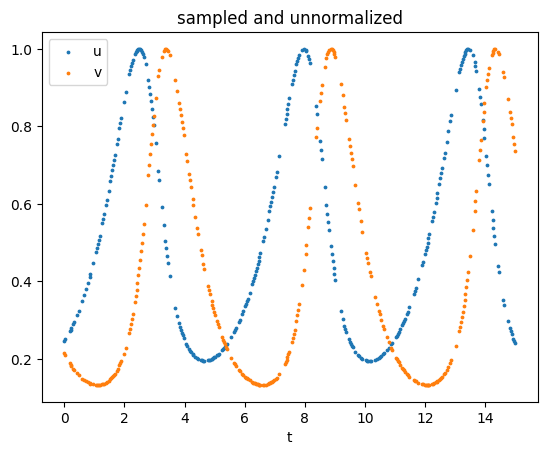

In [180]:
dataset = Dataset(
    create_data,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 300},
    preprocess_kwargs={
        "noise_level": 0.00,
        "normalize_coords": False,
        "normalize_data": True,
    },
    apply_normalize=custom_normalize,
    device=device
)
dataset.data.shape
fig, ax = plt.subplots()
ax.scatter(dataset.coords.cpu(), dataset.data[:, 0].cpu(), label="u", s=3)
ax.scatter(dataset.coords.cpu(), dataset.data[:, 1].cpu(), label="v", s=3)
ax.set_xlabel("t")
ax.legend()
ax.set_title("sampled and normalized")
plt.show()

In [181]:
 # see deepymod.data.base.get_train_test_loader for definition of `get_train_test_loader` function.
 # the shuffle is completely random mixing latter and earlier times
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

In [182]:
network = NN(1, [20, 20, 20, 20, 20, 20], 2)

In [183]:
library = Library1D(poly_order=1, diff_order=0) 

In [184]:
estimator = Threshold(0.5)
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-6)

In [185]:
constraint = LeastSquares()

In [186]:
model = DeepMoD(network, library, estimator, constraint)# .to(device)

In [187]:
model

DeepMoD(
  (func_approx): NN(
    (network): Sequential(
      (0): Linear(in_features=1, out_features=20, bias=True)
      (1): Tanh()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Tanh()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Tanh()
      (6): Linear(in_features=20, out_features=20, bias=True)
      (7): Tanh()
      (8): Linear(in_features=20, out_features=20, bias=True)
      (9): Tanh()
      (10): Linear(in_features=20, out_features=20, bias=True)
      (11): Tanh()
      (12): Linear(in_features=20, out_features=2, bias=True)
    )
  )
  (library): Library1D()
  (sparse_estimator): Threshold()
  (constraint): LeastSquares()
)

In [188]:
optimizer = torch.optim.Adam(
    model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3
)

In [189]:
%%time
! rm -rf ./data/deepymod/Lotka_Voltera/
foldername = "./data/deepymod/Lotka_Voltera/"
train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    log_dir=foldername,
    max_iterations=100000,
    delta=1e-3,
    patience=100,
)

  5025  MSE: 1.90e-05  Reg: 2.04e-04  L1: 7.64e+00 Algorithm converged. Writing model to disk.
CPU times: user 1min 4s, sys: 1.88 s, total: 1min 6s
Wall time: 1min 5s


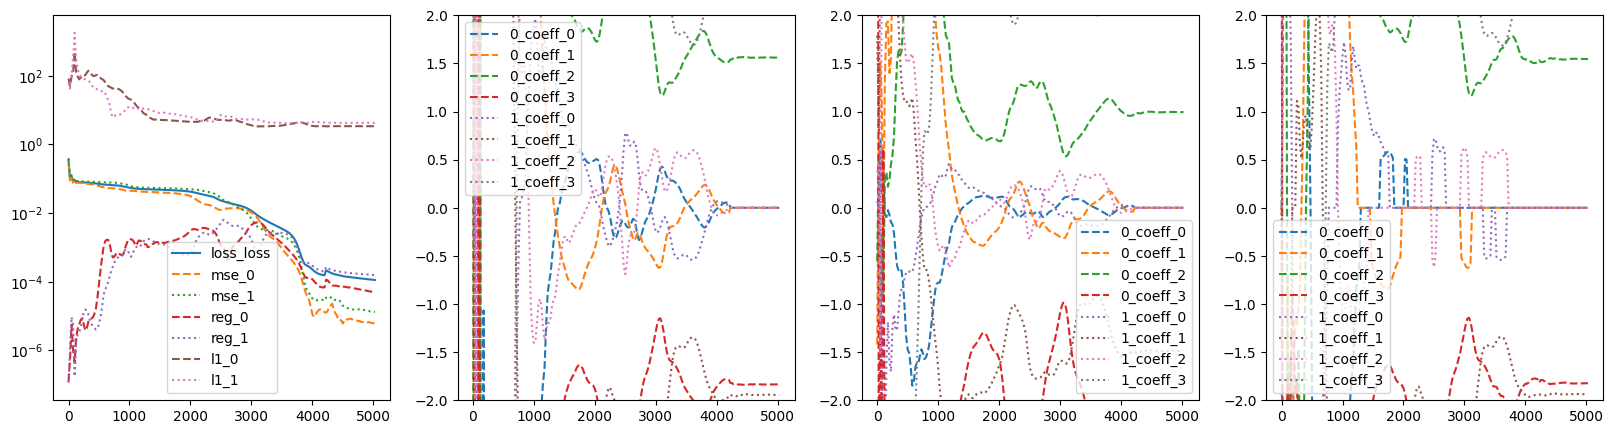

In [190]:
from deepymod.analysis import plot_history
plot_history(foldername)


In [191]:
model.sparsity_masks

[tensor([False, False,  True,  True]), tensor([False,  True, False,  True])]

In [192]:
model.constraint_coeffs()

[tensor([[ 0.0000],
         [ 0.0000],
         [ 0.9942],
         [-2.3164]], grad_fn=<MaskedScatterBackward0>),
 tensor([[ 0.0000],
         [-1.4880],
         [ 0.0000],
         [ 3.0265]], grad_fn=<MaskedScatterBackward0>)]

In [193]:
model.estimator_coeffs()

[array([[ 0.       ],
        [ 0.       ],
        [ 1.5454825],
        [-1.8230299]], dtype=float32),
 array([[ 0.       ],
        [-1.9369916],
        [ 0.       ],
        [ 2.2943435]], dtype=float32)]